# Model Development

This notebook demonstrates how to load models and datasets for model development. Note that this notebook is used for demonstration and debugging purposes only. 

For the actual model training, run `python src/train_cnn.py`:
```s
usage: train_cnn.py [-h] [--cnn_config CNN_CONFIG] [--lr_finder LR_FINDER] [--iso ISO [ISO ...]]

Model Training
options:
  -h, --help              show this help message and exit
  --cnn_config CNN_CONFIG Path to the configuration file
  --lr_finder LR_FINDER   Learning rate finder (boolean indicator)
  --iso ISO [ISO ...]     ISO 3166-1 alpha-3 codes
```

## Imports and Setup

In [1]:
import pandas as pd
import numpy as np
import geopandas as gpd

import os 
os.chdir('../')
from utils import cnn_utils
from utils import config_utils

import torchsummary
import torch

pd.set_option('mode.chained_assignment', None)
%load_ext autoreload
%autoreload 2

## Load Configuration

In [2]:
iso_code = "TJK"
config_file = "configs/cnn_configs/convnext_small.yaml"

config = config_utils.load_config(os.path.join(os.getcwd(), config_file))
config["iso_codes"] = [iso_code]
data, data_loader, classes = cnn_utils.load_dataset(config, phases=["train", "val", "test"])

INFO:root:
  rurban  iso       class  count  percentage
0  rural  TJK  non_school   1760    0.204058
1  rural  TJK      school   1051    0.121855
2  urban  TJK  non_school   3990    0.462609
3  urban  TJK      school   1824    0.211478
INFO:root:
                               count  percentage
rurban iso class      dataset                   
rural  TJK non_school test       164    0.190255
                      train     1423         NaN
                      val        173    0.200696
           school     test       116    0.134571
                      train      850         NaN
                      val         85    0.098608
urban  TJK non_school test       390    0.452436
                      train     3224         NaN
                      val        376    0.436195
           school     test       191    0.221578
                      train     1455         NaN
                      val        178    0.206497
INFO:root:
                    count  percentage
dataset class     

## Visualize Samples

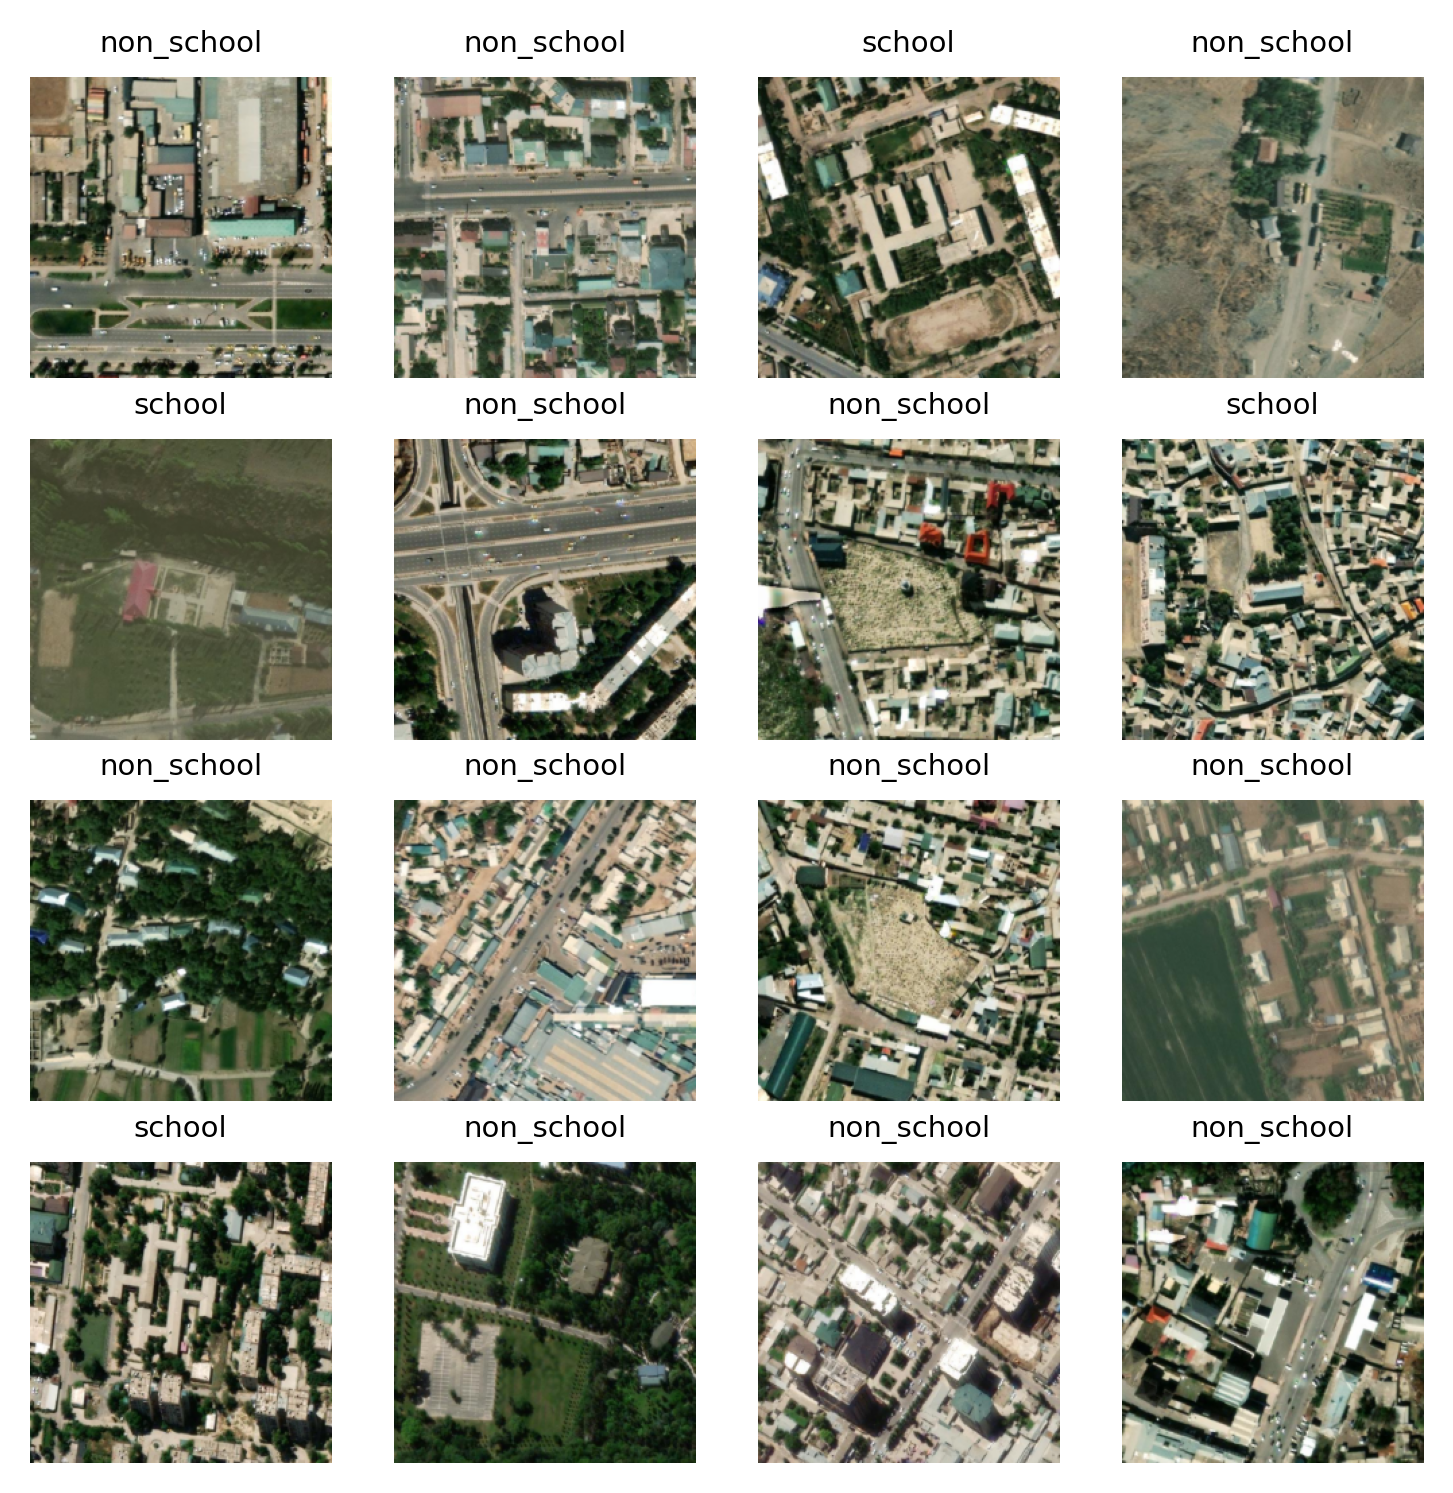

In [4]:
cnn_utils.visualize_data(data, data_loader, phase='train', normalize=config["normalize"])

## Load Model

In [67]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"
model, criterion, optimizer, scheduler = cnn_utils.load_model(
    n_classes=2,
    data_loader=data_loader,
    model_type=config["model"],
    pretrained=config["pretrained"],
    scheduler_type=config["scheduler"],
    optimizer_type=config["optimizer"],
    label_smoothing=config["label_smoothing"],
    lr=config["lr"],
    patience=config["patience"],
    lr_finder=False,
    device=device
)
#torchsummary.summary(model, (3, 500, 500))
model

DataParallel(
  (module): ConvNeXt(
    (features): Sequential(
      (0): Conv2dNormActivation(
        (0): Conv2d(3, 96, kernel_size=(4, 4), stride=(4, 4))
        (1): LayerNorm2d((96,), eps=1e-06, elementwise_affine=True)
      )
      (1): Sequential(
        (0): CNBlock(
          (block): Sequential(
            (0): Conv2d(96, 96, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=96)
            (1): Permute()
            (2): LayerNorm((96,), eps=1e-06, elementwise_affine=True)
            (3): Linear(in_features=96, out_features=384, bias=True)
            (4): GELU(approximate='none')
            (5): Linear(in_features=384, out_features=96, bias=True)
            (6): Permute()
          )
          (stochastic_depth): StochasticDepth(p=0.0, mode=row)
        )
        (1): CNBlock(
          (block): Sequential(
            (0): Conv2d(96, 96, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=96)
            (1): Permute()
            (2): LayerNorm((96,)

## Learning Rate Finder

  0%|          | 0/50 [00:00<?, ?it/s]

Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 7.91E-04


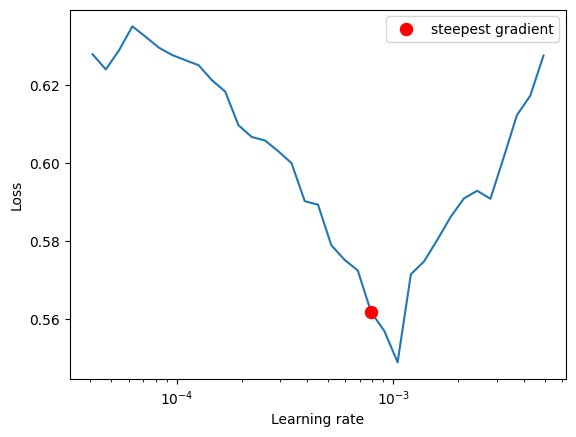

INFO:root:Best lr: 0.0007906043210907702


In [22]:
lr = cnn_utils.run_lr_finder(
    data_loader, 
    model, 
    optimizer, 
    criterion, 
    device,
    start_lr=1e-5,
    end_lr=1e-2, 
    num_iter=50, 
    plot=True
)